In [2]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [3]:
#hide
from fastbook import *
from fastai.tabular.all import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs
from sklearn.inspection._partial_dependence import partial_dependence

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [4]:
path = Path('~/NKI_cleaned.csv')

In [5]:
#Read in dataset
df = pd.read_csv('https://query.data.world/s/nwxsfhjpvxclzg63ulbhgb4yhf46hh')
df.head()

,Patient,ID,age,eventdeath,...,Contig46616_RC,NM_000888,NM_000898,AF067420
0,s122,18,43,0,...,0.237856,-0.087631,-0.369153,0.153795
1,s123,19,48,0,...,-0.466537,-0.231547,-0.643019,-0.014098
2,s124,20,38,0,...,0.110155,-0.114298,0.258495,-0.198911
3,s125,21,50,0,...,-0.016790,-0.285344,-0.251188,0.862710
4,s126,22,38,0,...,-0.405853,-0.053601,-0.677072,0.134160


In [6]:
#Create a dataloaders object
dls = TabularDataLoaders.from_csv('https://query.data.world/s/nwxsfhjpvxclzg63ulbhgb4yhf46hh', path = path, y_names="eventdeath",
                                 cat_names = ['survival', 'chemo', 'hormonal', 'amputation', 'histtype', 'grade', 'angioinv', 'lymphinfil'],
                                cont_names = ['ID', 'age', 'timerecurrence', 'diam', 'posnodes', 'esr1'],
                                  procs = [Categorify, FillMissing, Normalize])

In [7]:
#Specify conditions on which to split dataset
cond = (df.ID<220)
train_idx = np.where( cond)[0]
valid_idx = np.where(-cond)[0]

splits = (list(train_idx), list(valid_idx))

In [8]:
to = TabularPandas(df, procs=[Categorify, FillMissing],
                   cat_names = ['survival', 'chemo', 'hormonal', 'amputation', 'histtype', 'grade', 'angioinv', 'lymphinfil'],
                   cont_names = ['age', 'timerecurrence', 'diam', 'posnodes', 'esr1'],
                   y_names='eventdeath',
                   splits=splits)

In [9]:
to.show(3)

,survival,chemo,hormonal,amputation,histtype,grade,angioinv,lymphinfil,age,timerecurrence,diam,posnodes,esr1,eventdeath
0,14.8172,0,0,1,1,2,3,1,43,14.817248,25,0,-0.413955,0
1,14.2615,0,0,0,1,3,3,1,48,14.261465,20,0,0.195251,0
2,6.64476,0,0,0,1,2,1,1,38,6.644764,15,0,0.596177,0


In [10]:
to.items.head(3)

,Patient,ID,age,eventdeath,...,Contig46616_RC,NM_000888,NM_000898,AF067420
0,s122,18,43,0,...,0.237856,-0.087631,-0.369153,0.153795
1,s123,19,48,0,...,-0.466537,-0.231547,-0.643019,-0.014098
2,s124,20,38,0,...,0.110155,-0.114298,0.258495,-0.198911


In [11]:
to.classes['histtype']

['#na#', 1, 2, 5, 7]

In [12]:
#Define indep and dep variables
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [13]:
dec_class = DecisionTreeClassifier(max_leaf_nodes=4)
dec_class.fit(xs, y)

DecisionTreeClassifier(max_leaf_nodes=4)

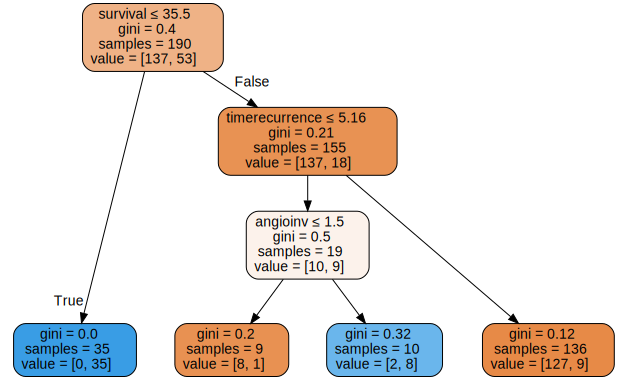

In [14]:
draw_tree(dec_class, xs, size=10, leaves_parallel=True, precision=2)

In [15]:
#remove all stopping criteria
dec_class = DecisionTreeClassifier()
dec_class.fit(xs, y);

In [16]:
#Predict against validation data
dec_class_pred = dec_class.predict(valid_xs)

In [17]:
#Evaluating the model (1)
#compute accuracy score
dec_class_acc_score = accuracy_score(valid_y, dec_class_pred)
print(dec_class_acc_score)

0.34146341463414637


In [18]:
#Evaluating the model (2)
#compute classification report
print(classification_report(valid_y, dec_class_pred))

#Model has high precision/low recall for outcome 0 and low precision/high recall for outcome 1 and has an accuracy of 
#0.34 (which is not great)

              precision    recall  f1-score   support

           0       1.00      0.07      0.13        58
           1       0.31      1.00      0.47        24

    accuracy                           0.34        82
   macro avg       0.65      0.53      0.30        82
weighted avg       0.80      0.34      0.23        82



In [19]:
#Print AUC score

roc_auc_score(valid_y, dec_class_pred, average = None)

0.5344827586206897

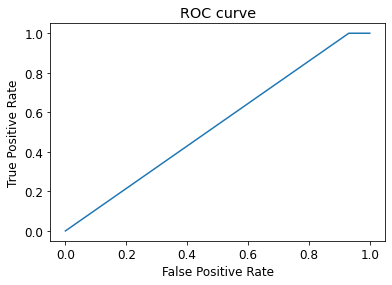

In [20]:
#Plot Decision Tree ROC curve
fpr, tpr, thresholds = roc_curve(valid_y, dec_class_pred)

plt.plot(fpr, tpr, label = 'Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [21]:
#Random Forests

In [22]:
#Create random forest function 
def rf(xs, y, n_estimators=40, max_samples=190,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [24]:
#Create Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=40, max_depth = 6, random_state = 1111)

In [25]:
#train
rfc.fit(xs, y)

RandomForestClassifier(max_depth=6, n_estimators=40, random_state=1111)

In [26]:
#Create predictions on test data
predictions = rfc.predict(valid_xs)
print(predictions[0:5])

[0 0 0 0 0]


In [27]:
probs = rfc.predict_proba(valid_xs)
print(probs[0:5])

[[0.58771138 0.41228862]
 [0.59579465 0.40420535]
 [0.51305837 0.48694163]
 [0.59183541 0.40816459]
 [0.58617066 0.41382934]]


In [28]:
#Model accuracy - how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(valid_y, predictions))

Accuracy: 0.9024390243902439


In [29]:
#Print ROC, classification report and confusion matrix
print(roc_auc_score(valid_y, probs[:,1]))
print(classification_report(valid_y, predictions))
print(confusion_matrix(valid_y, predictions))

#The random forest has a much higher precision and recall than the decision tree for both outcomes. Accuracy also much 
#higher at 0.90 cf 0.34 for decision tree. This model is performing much better than the decision tree on the data.

0.942528735632184
              precision    recall  f1-score   support

           0       0.98      0.88      0.93        58
           1       0.77      0.96      0.85        24

    accuracy                           0.90        82
   macro avg       0.87      0.92      0.89        82
weighted avg       0.92      0.90      0.91        82

[[51  7]
 [ 1 23]]


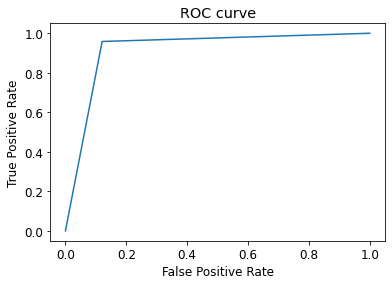

In [30]:
#Plot Random Forest ROC curve
fpr, tpr, thresholds = roc_curve(valid_y, predictions)

plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [31]:
#USING A NEURAL NETWORK

In [32]:
df_nn = pd.read_csv('https://query.data.world/s/nwxsfhjpvxclzg63ulbhgb4yhf46hh', low_memory=False)

In [33]:
df_nn_final = df_nn[list(valid_xs.columns) + ['eventdeath']]

In [34]:
#Use of embeddings to handle categorical variables in neural network 
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=34, dep_var = 'eventdeath' )

In [35]:
cont_nn

['survival', 'timerecurrence', 'esr1']

In [36]:
#look at cardinality of each of categorical variables chosen
df_nn_final[cat_nn].nunique()

chemo          2
hormonal       2
amputation     2
histtype       5
grade          3
angioinv       3
lymphinfil     3
age           27
diam          34
posnodes      12
dtype: int64

In [37]:
#create tabular pandas object and normalise
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names='eventdeath', y_block = CategoryBlock)

In [38]:
dls = to_nn.dataloaders(20)

In [39]:
#Show a batch
dls.show_batch()

,chemo,hormonal,amputation,histtype,grade,angioinv,lymphinfil,age,diam,posnodes,survival,timerecurrence,esr1,eventdeath
0,1,1,0,1,2,3,1,43,22,4,9.314168,8.394251,0.160823,0
1,1,0,0,1,3,3,2,32,25,5,2.587269,1.716632,-0.987391,1
2,1,1,0,1,1,1,1,50,25,1,8.739220,8.739220,0.273410,0
3,0,0,0,1,1,3,1,42,13,0,8.963723,5.516769,-0.373530,0
4,1,0,0,1,1,1,1,40,15,1,8.240931,8.240931,0.112605,0
5,0,0,0,1,3,3,1,42,26,0,2.151951,1.007529,-1.262985,1
6,0,0,1,1,1,1,1,45,15,1,6.609172,6.609172,0.212904,0
7,1,0,1,1,1,1,1,47,25,2,11.195072,11.195072,0.081947,0
8,1,0,0,1,2,3,1,43,20,1,10.767967,10.767967,0.330859,0
9,0,0,1,1,3,2,1,49,50,0,18.340862,18.340862,0.582304,0


In [40]:
#set y-range for classification model - find min and max of dependent variable
y = to_nn.train.y
y.min(), y.max()

(0, 1)

In [41]:
#Create learner to create tabular model (CHANGE LAYERS TO 10, 1 OR 5, 10). Also changed F.mse_loss to F.nll_loss
learn = tabular_learner(dls, y_range=(0,1), layers=[5,10],
                        n_out=1, loss_func=F.nll_loss)

In [42]:
learn = tabular_learner(dls, metrics=accuracy)

In [43]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.559243,0.677095,0.658537,00:00


In [44]:
learn.show_results()

,chemo,hormonal,amputation,histtype,grade,angioinv,lymphinfil,age,diam,posnodes,survival,timerecurrence,esr1,eventdeath,eventdeath_pred
0,1.0,2.0,2.0,1.0,3.0,1.0,1.0,0.0,24.0,2.0,1.453042,1.526014,-0.092521,0.0,0.0
1,1.0,1.0,2.0,1.0,2.0,2.0,1.0,22.0,13.0,1.0,2.516120,2.509427,-0.995260,0.0,0.0
2,1.0,1.0,2.0,1.0,2.0,1.0,1.0,12.0,24.0,1.0,-0.696634,-1.047682,0.605379,1.0,1.0
3,1.0,1.0,2.0,1.0,2.0,2.0,1.0,12.0,14.0,1.0,-0.424131,-0.993335,-1.797716,1.0,1.0
4,1.0,1.0,2.0,1.0,2.0,3.0,1.0,0.0,9.0,1.0,1.151603,1.247164,0.780659,0.0,0.0
5,1.0,1.0,1.0,1.0,2.0,1.0,1.0,20.0,11.0,1.0,-0.766134,-0.526861,0.696033,0.0,1.0
6,1.0,1.0,1.0,1.0,2.0,3.0,1.0,20.0,6.0,1.0,-1.274593,-1.527743,-0.915047,1.0,1.0
7,2.0,1.0,2.0,1.0,2.0,3.0,1.0,22.0,22.0,2.0,-0.283553,-0.080443,0.692130,0.0,0.0
8,2.0,1.0,1.0,1.0,3.0,1.0,1.0,0.0,24.0,2.0,2.347566,2.353504,-0.008745,0.0,0.0


In [45]:
#Alternatively, can use the predict method on a row of data

row, clas, probs = learn.predict(df.iloc[0])

In [46]:
row.show()

,chemo,hormonal,amputation,histtype,grade,angioinv,lymphinfil,age,diam,posnodes,survival,timerecurrence,esr1,eventdeath
0,0,0,1,1,2,3,1,43,25,0,14.817248,14.817248,-0.413955,0


In [47]:
preds,targs = learn.get_preds()
accuracy(preds,targs)

TensorBase(0.6585)

In [48]:
#ML EXPLAINABILITY

In [49]:
#FEATURE IMPORTANCE

In [50]:
def rf_feat_importance(rfc, df):
    return pd.DataFrame({'cols':df.columns, 'imp':rfc.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [51]:
#The feature importances for the model show that the first few variables have the highest importance scores
fi = rf_feat_importance(rfc, xs)
fi[:10]

,cols,imp
9,timerecurrence,0.354612
0,survival,0.302865
12,esr1,0.098139
5,grade,0.058233
8,age,0.054239
10,diam,0.040623
11,posnodes,0.037985
6,angioinv,0.019301
4,histtype,0.011229
7,lymphinfil,0.010190


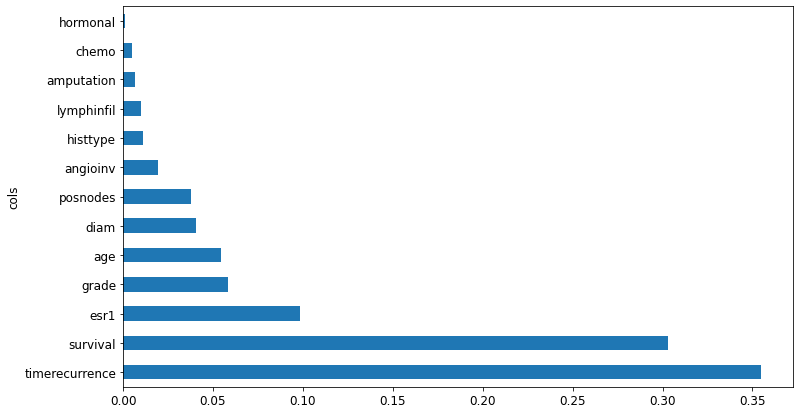

In [52]:
#Plot of the feature importances
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [53]:
#Remove low importance variables (keeping all feature importance variables >0.005)
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

12

In [54]:
#Re-train model using just this subset of columns
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

rfc_imp = rfc.fit(xs_imp, y)

In [55]:
#Create predictions on improved test data
pred_imp = rfc_imp.predict(valid_xs_imp)
print(predictions[0:5])

[0 0 0 0 0]


In [56]:
#Model accuracy - how often is the improved classifier correct?
print("Accuracy:",metrics.accuracy_score(valid_y, pred_imp))

#Can't explain why having removed the 13th column (hormonal) of low implied feature importance, has caused model accura
#cy to plummet from 90% to 74%

Accuracy: 0.7439024390243902


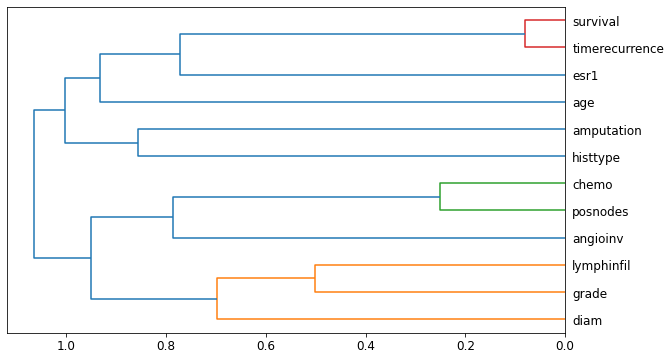

In [57]:
#Check for and remove redundant features if present 
cluster_columns(xs_imp)

#No redundant features appear here

In [58]:
#PARTIAL DEPENDENCE PLOTS

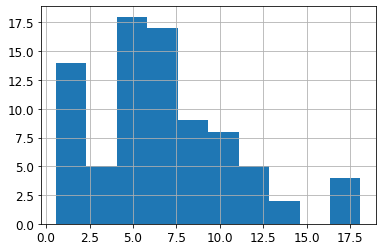

In [59]:
#As seen above, the 2 most important predictors are "timerecurrence" and "survival". Next, investigate to better unders
#stand the relationship between these 2 variables and the outcome variable "eventdeath"

#Histogram plot of timerecurrence (being a numerical variable)
ax = valid_xs_imp['timerecurrence'].hist()

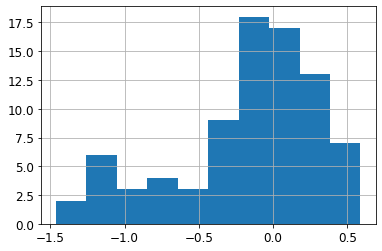

In [60]:
#Histogram plot of esr1
ay = valid_xs_imp['esr1'].hist()

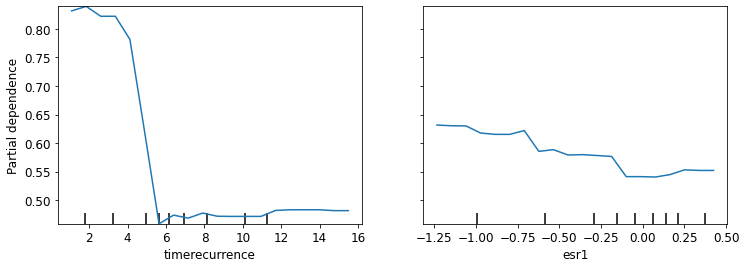

In [61]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(rfc, valid_xs_imp, ['timerecurrence','esr1'],
                        grid_resolution=20, ax=ax);

#below, with the averages, we've plotted each predictor on the x-axis and each of the predictions on the y-axis. This is
#a partial dependence plot

In [62]:
#SHAP VALUES
#These break down a prediction to show the impact of each feature

In [63]:
pip install fastinference[interp]

     |████████████████████████████████| 26.5 MB 22.9 MB/s eta 0:00:01
     |████████████████████████████████| 273 kB 36.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 30.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 16.9 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.0 MB/s  eta 0:00:01
     |████████████████████████████████| 233 kB 27.6 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 23.4 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp38-cp38-linux_x86_64.whl size=403272 sha256=4fc67d139c2688b4541f8ed619568c291d8e8435f4354b6e3e4790b92c294d92
  Stored in directory: /root/.cache/pip/wheels/5d/f0/73/1bdbcc3c8224e1a57f954d3577fabdd0052ea39f5e8dac04ac
Successfully built shap
Note: you may need to restart the kernel to use updated packages.


In [64]:
from fastinference.tabular import *

In [65]:
learn = tabular_learner(dls, layers=[10,5], metrics=accuracy)
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.593794,0.606123,0.707317,00:00


In [66]:
exp = ShapInterpretation(learn, df.iloc[:100])

In [67]:
#DECISION PLOT

In [68]:
#Looking at 10th row of the dataframe
df.iloc[10]

Patient               s132
ID                      28
age                     47
eventdeath               0
survival           6.71869
                    ...   
Contig29014_RC   -0.018924
Contig46616_RC   -0.499796
NM_000888          -0.0941
NM_000898        -0.278633
AF067420         -0.455123
Name: 10, Length: 1570, dtype: object

Classification model detected, displaying score for the class 0.
(use `class_id` to specify another class)
Displaying row 10 of 100 (use `row_idx` to specify another row)


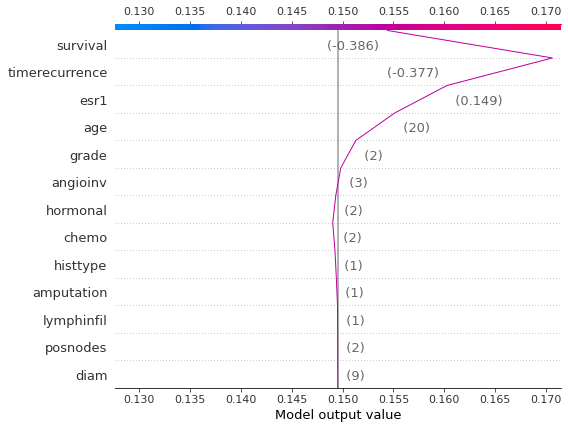

In [69]:
exp.decision_plot(class_id=0, row_idx=10)

In [70]:
#DEPENDENCY PLOT

Classification model detected, displaying score for the class 0.
(use `class_id` to specify another class)


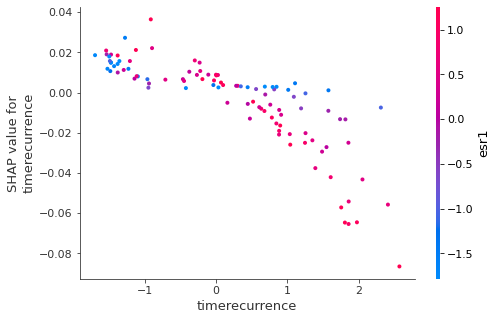

In [72]:
exp.dependence_plot('timerecurrence', class_id=0)

In [73]:
#FORCE PLOT

In [74]:
exp.force_plot(class_id=1)

Classification model detected, displaying score for the class 1.
(use `class_id` to specify another class)


In [75]:
#SUMMARY PLOT

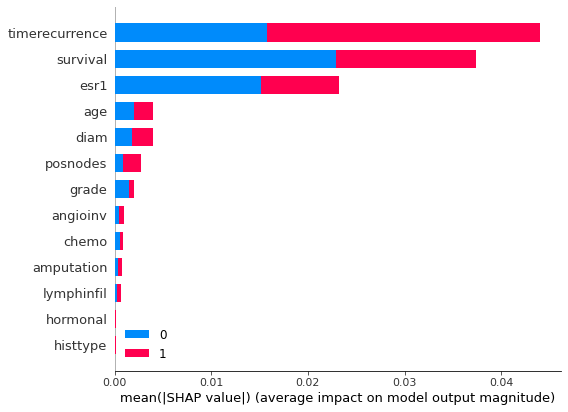

In [76]:
exp.summary_plot()

In [77]:
#WATERFALL PLOT

In [82]:
exp.waterfall_plot(row_idx=10, class_id='0')

KeyError: '0'